In [22]:
import pandas as pd # Dataframe (allows for multiple different structures/data types in one database frame)
import numpy as np # Array style (only one data-type is allowed)
import matplotlib.pyplot as plt   # The default processing plot platform for python
import seaborn as sns  # A fancier way to plot things with nice animations and color

import scipy.stats as stats
import statsmodels.api as sm      # Scipy or sklearn or statmodels.api
import statsmodels.formula.api as smf # A way to do forward and backward selections

from statsmodels.graphics.plot_grids import scatter_ellipse
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

import matplotlib.lines as mlines
import matplotlib.transforms as mtransform


import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import metrics

%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import GroupShuffleSplit
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed







%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit


     

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

In [23]:
##### THE BELOW CODE IS ADAPTED FROM KOEN PETERS BLOG POST: 
#https://towardsdatascience.com/predictive-maintenance-of-turbofan-engines-ec54a083127

In [24]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [25]:
index_names = ['engine_id', 'cycle_num']
operation_names = ['condition_1', 'condition_2', 'condition_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)] 
col_names = index_names + operation_names + sensor_names


train = pd.read_csv(('train_data.csv'), header=0, names=col_names)
test = pd.read_csv(('test_data.csv'), header=0, names=col_names)
y_test = pd.read_csv(('RUL_forecast_length.csv'), header=0, names=['RUL'])


train.head()

engine_id  cycle_num  condition_1  condition_2  condition_3  sensor_1  \
0          1          1      -0.0007      -0.0004        100.0    518.67   
1          1          2       0.0019      -0.0003        100.0    518.67   
2          1          3      -0.0043       0.0003        100.0    518.67   
3          1          4       0.0007       0.0000        100.0    518.67   
4          1          5      -0.0019      -0.0002        100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.03        392       2388      100.0   
1    8131.49     8.4318       0.03        392       2388      100.0   
2    8133.23     8.4178       0.03        390       2388      100.0   
3    8133.83     8.3682       0.03        392       2388      100.0   
4    8133.80     8.4294       0.03        393       2388      100.0   

   sensor_20  sensor_21  
0      39.06    23.4190  
1      39.00    23.4236  
2      38.95    23.3442  
3      38.88    23.3739  
4      38.90    23.4044  

[5 rows x 26 columns]

In [26]:
def add_remaining_useful_life(df):
    
    grouped_by_unit = df.groupby(by="engine_id")
    max_cycle = grouped_by_unit["cycle_num"].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine_id', right_index=True)
    
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle_num"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']]

engine_id  cycle_num  RUL
0             1          1  191
1             1          2  190
2             1          3  189
3             1          4  188
4             1          5  187
...         ...        ...  ...
9904         50        194    4
9905         50        195    3
9906         50        196    2
9907         50        197    1
9908         50        198    0

[9909 rows x 3 columns]

In [27]:
X_train = train[sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop(['cycle_num']+operation_names, axis=1).groupby('engine_id').last().copy()  # get the last row of each engine

In [28]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [29]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)


train set RMSE:20.38666256537714, R2:0.7619107981603818
test set RMSE:24.02836199083954, R2:-1.7724474427986663


In [30]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    

    df_op_cond['condition_1'] = df_op_cond['condition_1'].round()
    
    df_op_cond['condition_2'] = df_op_cond['condition_2'].round(decimals=2)
    
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['condition_1'].astype(str) + '_' + \
                        df_op_cond['condition_2'].astype(str) + '_' + \
                        df_op_cond['condition_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    
    scaler = StandardScaler()
    
    for condition in df_train['op_cond'].unique():
        print(condition)
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [31]:
X_train_condition = add_operating_condition(train)

X_test_condition = add_operating_condition(test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)


-0.0_-0.0_100.0
0.0_-0.0_100.0
-0.0_0.0_100.0
0.0_0.0_100.0


In [32]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['engine_id']==unit_nr])
    else:
        for i in train['engine_id'].unique():
            if (i % 10 == 0):  
                plt.plot('RUL', signal_name, 
                         data=df[df['engine_id']==i])
    plt.xlim(250, 0) 
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

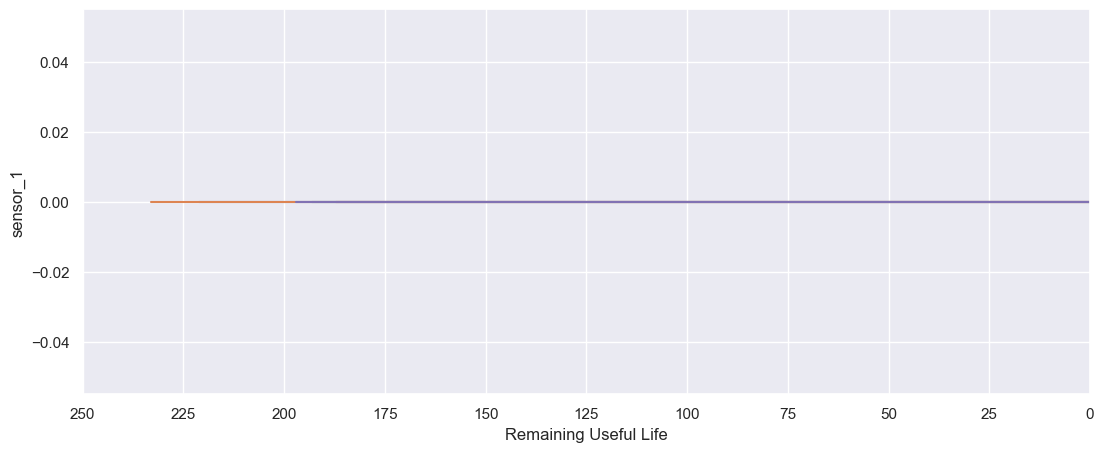

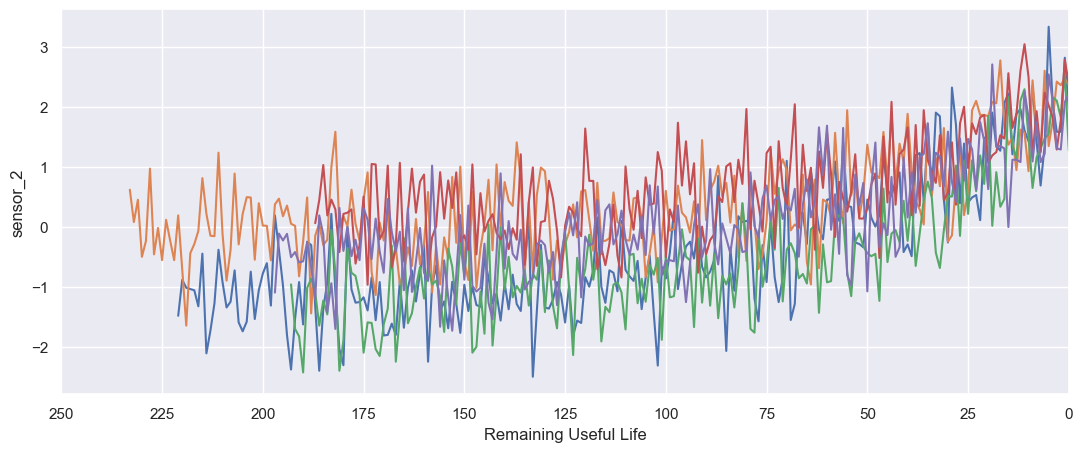

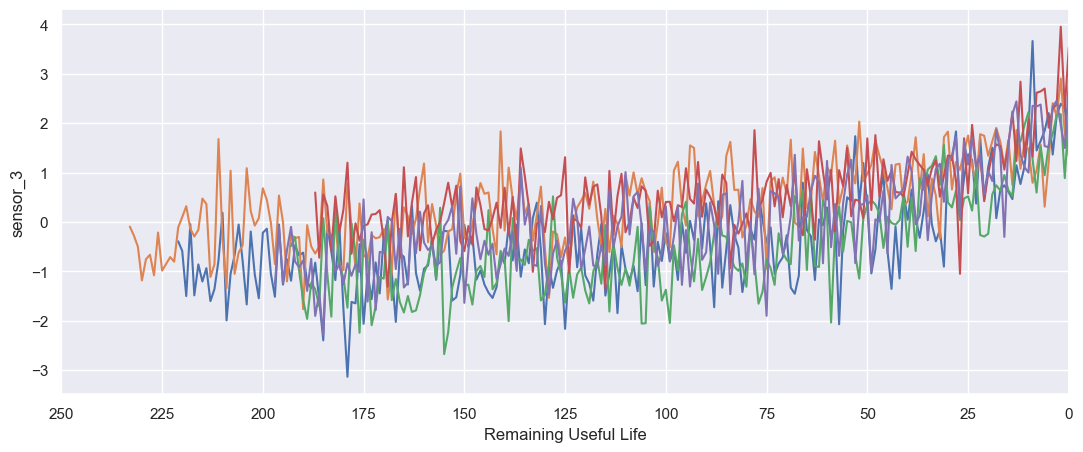

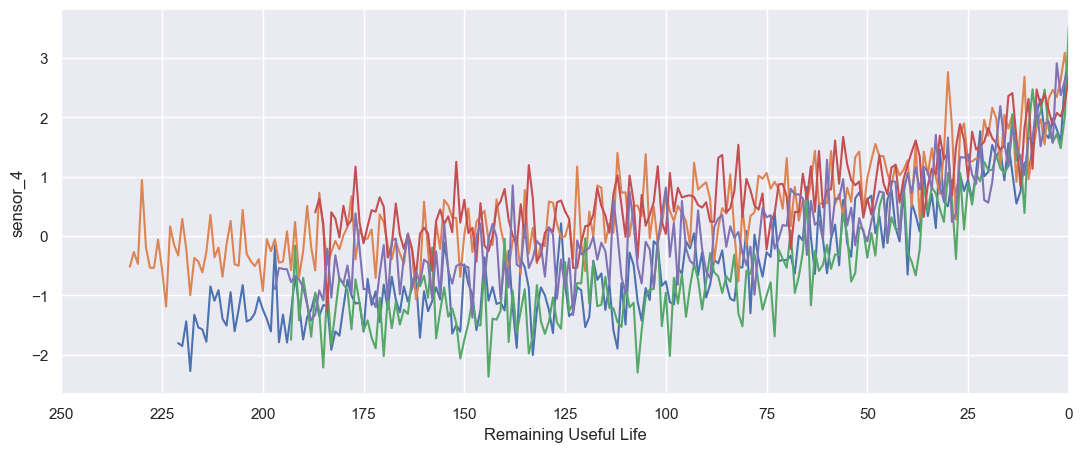

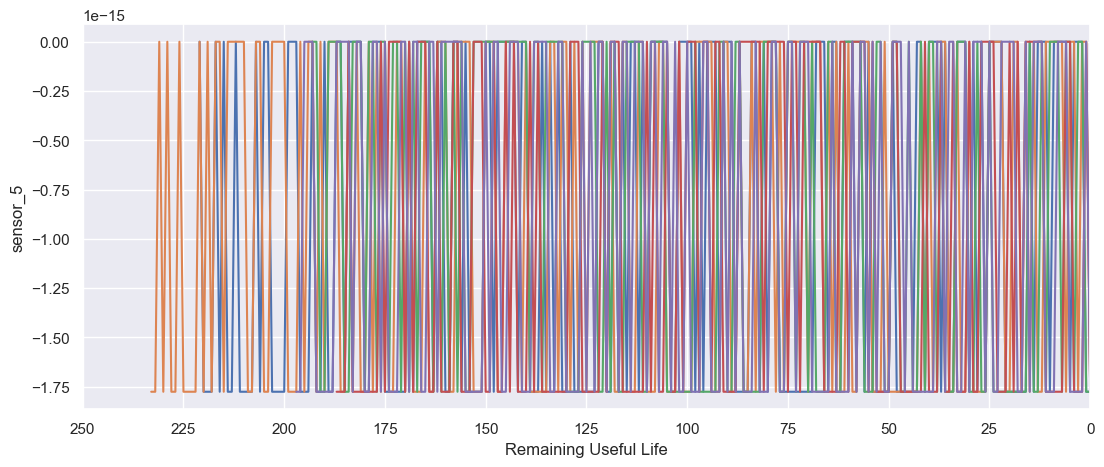

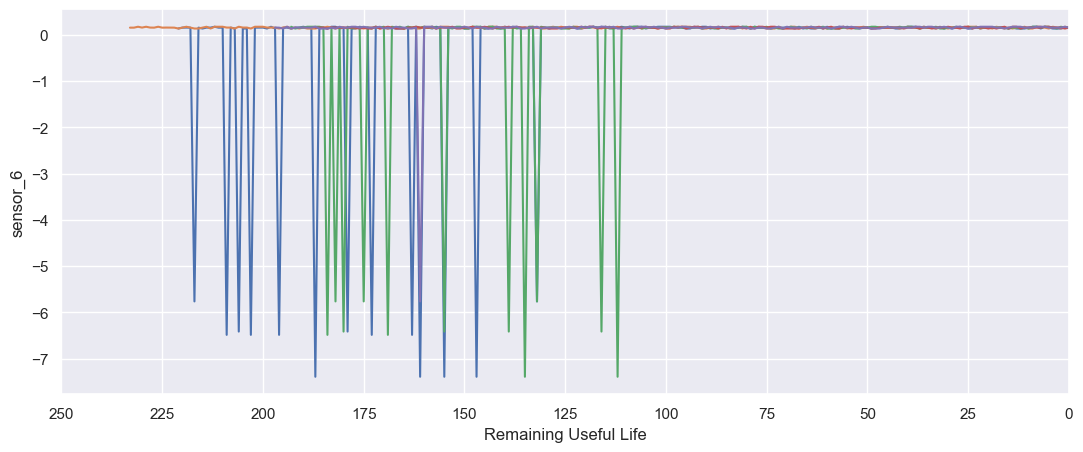

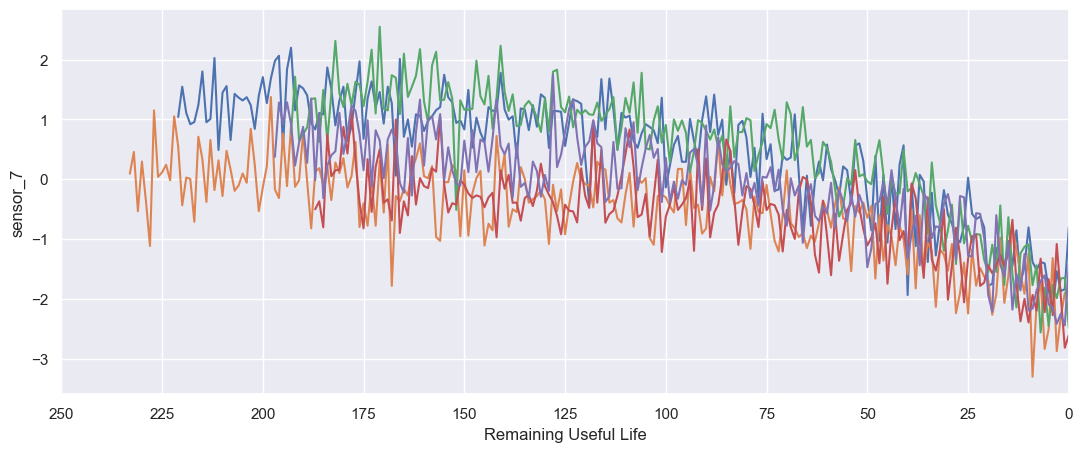

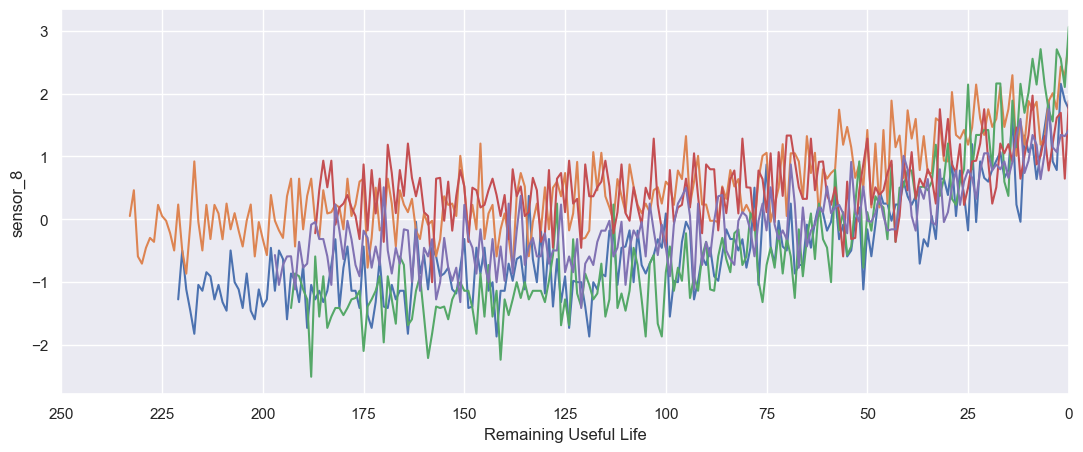

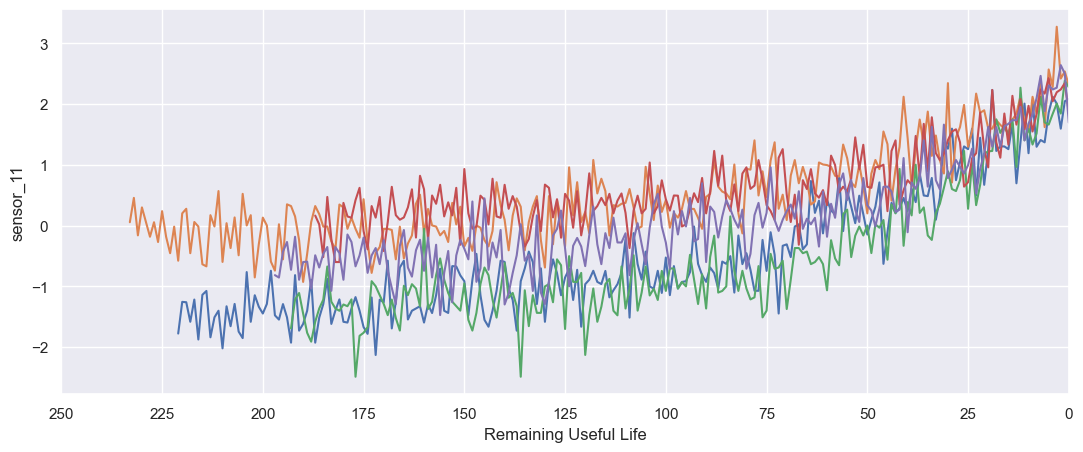

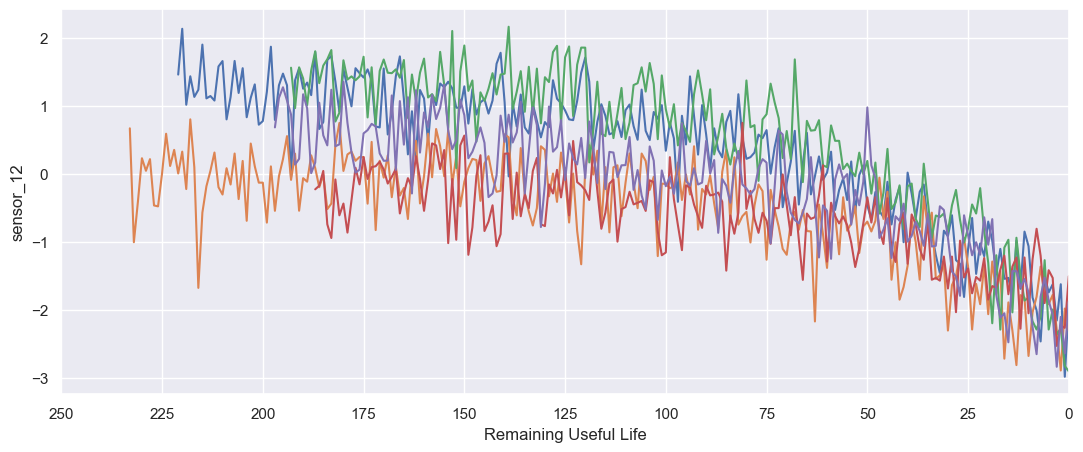

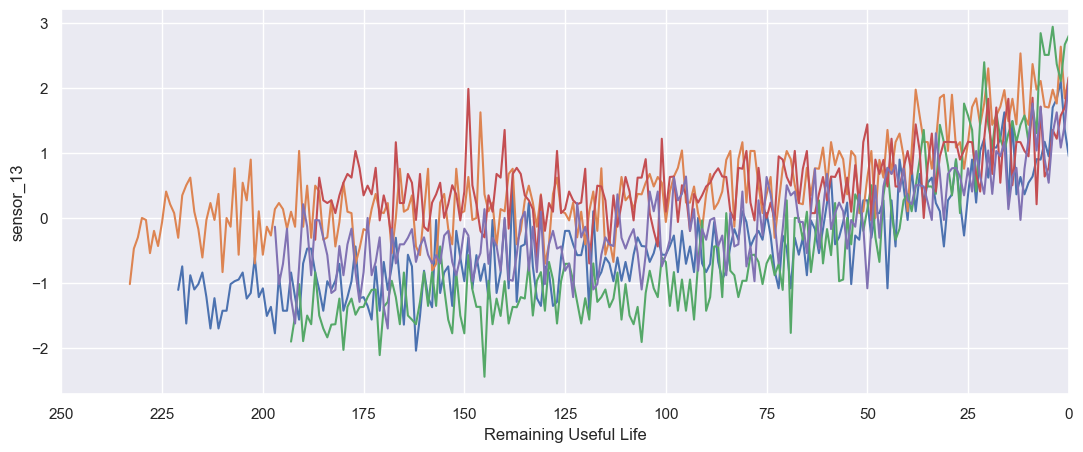

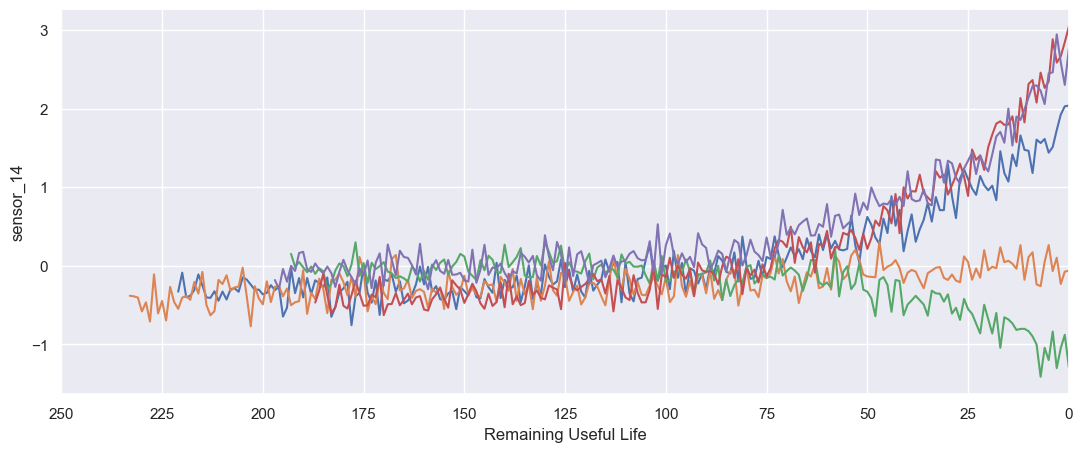

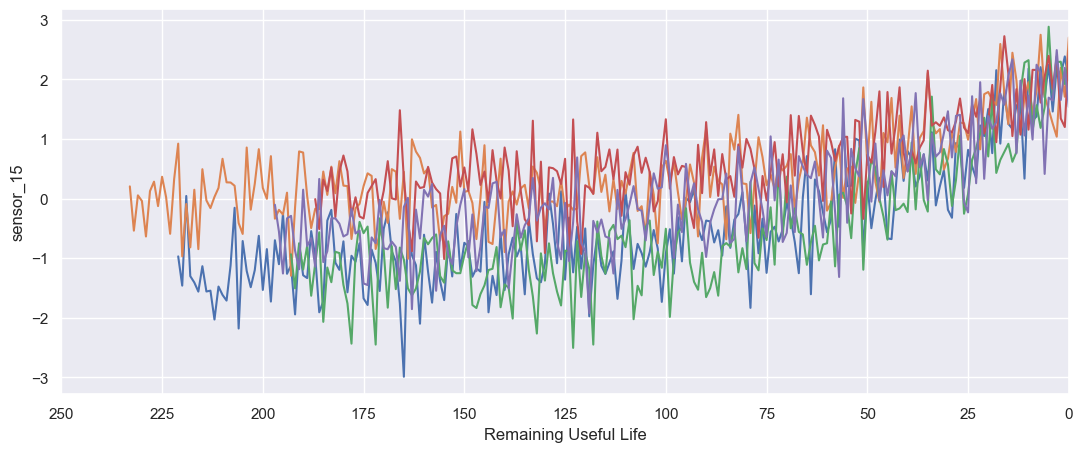

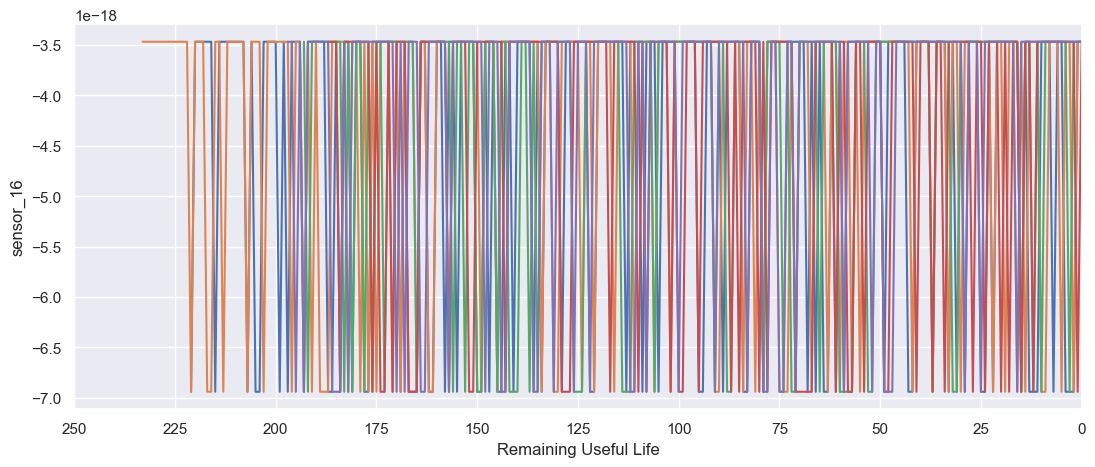

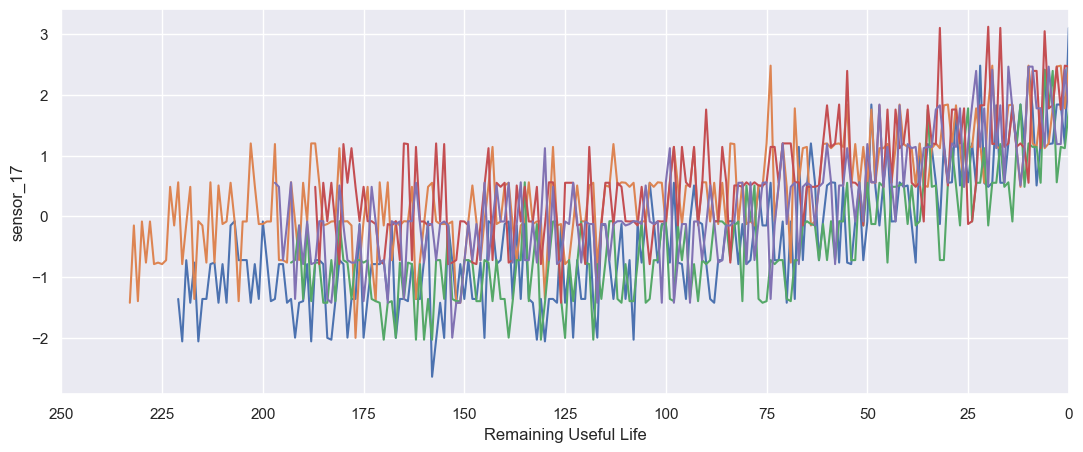

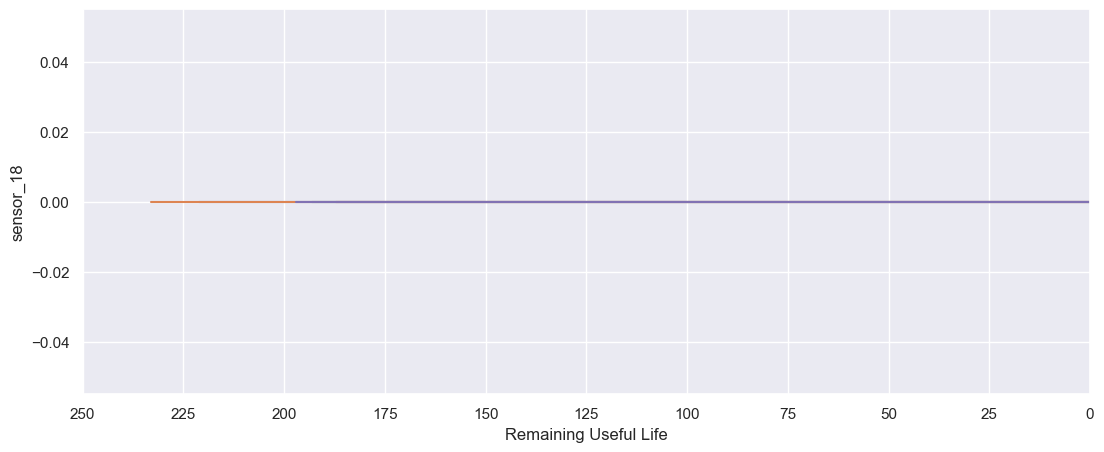

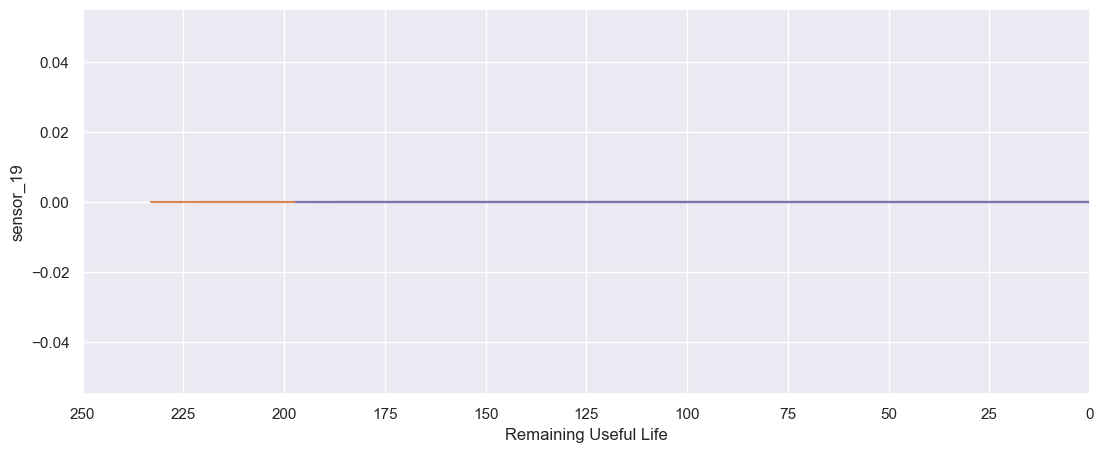

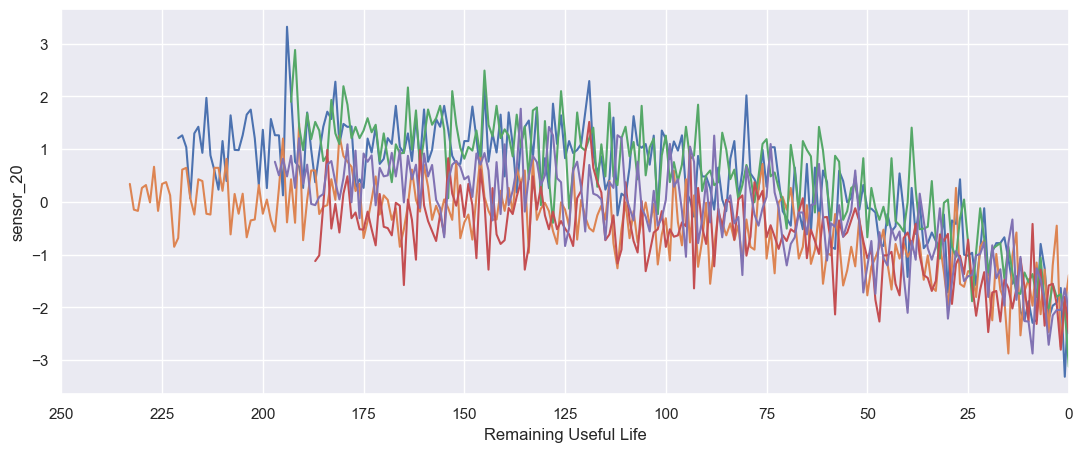

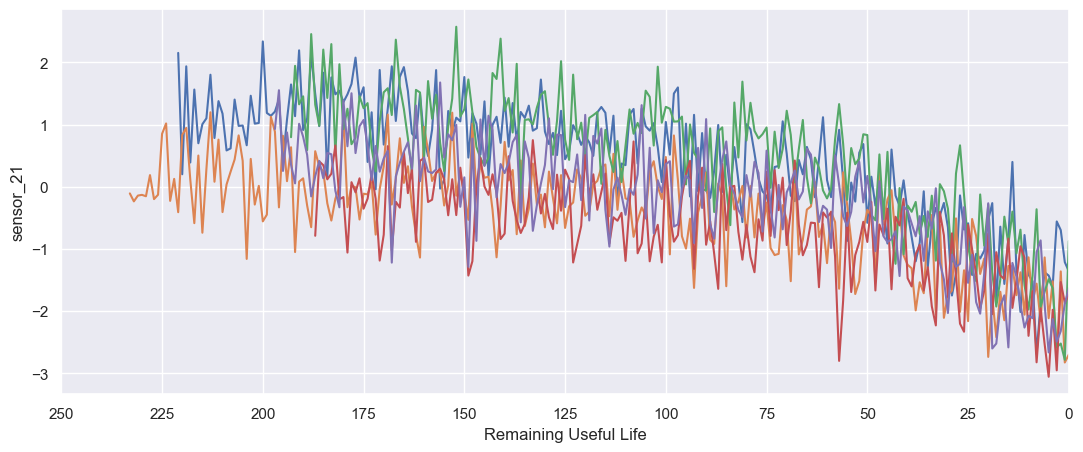

In [33]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)


In [65]:
drop_sensors = ['sensor_1','sensor_5','sensor_6','sensor_10','sensor_16','sensor_18','sensor_19']
remaining_sensors = [element for element in sensor_names if element not in drop_sensors]

In [66]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('engine_id')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('engine_id')['engine_id'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [67]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['engine_id'].unique())
            print('validate_split_engines', train.iloc[idx_val]['engine_id'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

In [68]:
d = {'engine_id': [1]*5 + [2]*5,
     'X': [10., 10.2, 10.4, 10.6, 10.8, 20., 20.2, 20.4, 20.6, 20.8],
     'y': [1.4, 1.4, 1.3, 1.2, 1.1, 2.4, 2.4, 2.3, 2.2, 2.1]}
example_df = pd.DataFrame(data=d)
example_df


engine_id     X    y
0          1  10.0  1.4
1          1  10.2  1.4
2          1  10.4  1.3
3          1  10.6  1.2
4          1  10.8  1.1
5          2  20.0  2.4
6          2  20.2  2.4
7          2  20.4  2.3
8          2  20.6  2.2
9          2  20.8  2.1

In [69]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [70]:
gen = gen_train_data(example_df[example_df['engine_id']==1], sequence_length=4, columns=['X'])
list(gen)


[array([[10. ],
        [10.2],
        [10.4],
        [10.6]]),
 array([[10.2],
        [10.4],
        [10.6],
        [10.8]])]

In [71]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['engine_id'].unique()
        
    data_gen = (list(gen_train_data(df[df['engine_id']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [72]:
data_array = gen_data_wrapper(example_df, sequence_length=4, columns=['X'])
data_array

array([[[10. ],
        [10.2],
        [10.4],
        [10.6]],

       [[10.2],
        [10.4],
        [10.6],
        [10.8]],

       [[20. ],
        [20.2],
        [20.4],
        [20.6]],

       [[20.2],
        [20.4],
        [20.6],
        [20.8]]], dtype=float32)

In [73]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['engine_id'].unique()
        
    label_gen = [gen_labels(df[df['engine_id']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [74]:
label = gen_labels(example_df[example_df['engine_id']==1], sequence_length=4, label=['y'])
label

array([[1.2],
       [1.1]])

In [75]:
label_array = gen_label_wrapper(example_df, sequence_length=4, label=['y'])
label_array

array([[1.2],
       [1.1],
       [2.2],
       [2.1]], dtype=float32)

In [76]:
# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
b = np.full(shape=(2,3), fill_value=0.)  # available sequence length

idx = a.shape[0] - b.shape[0]  # equals to 3

a[idx:,:] = b
a

array([[-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.]])

In [77]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) 
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  
    else:
        data_matrix = df[columns].values
        

    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :] 

In [78]:
gen = (list(gen_test_data(example_df[example_df['engine_id']==engine_id], sequence_length=6, columns=['X'], mask_value=-99.))
           for engine_id in example_df['engine_id'].unique())
next(gen)


[array([[-99. ],
        [ 10. ],
        [ 10.2],
        [ 10.4],
        [ 10.6],
        [ 10.8]])]

In [79]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['engine_id'].unique(), groups=X_train_interim['engine_id'].unique()):
    train_unit = X_train_interim['engine_id'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['engine_id'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['engine_id']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['engine_id'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

-0.0_-0.0_100.0
0.0_-0.0_100.0
-0.0_0.0_100.0
0.0_0.0_100.0


In [80]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

2022-12-07 17:50:58.440464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [81]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [82]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)


Epoch 1/20
222/222 [==============================] - 8s 15ms/step - loss: 6959.7900 - val_loss: 6400.1816
Epoch 2/20
222/222 [==============================] - 2s 9ms/step - loss: 5595.1260 - val_loss: 5404.7363
Epoch 3/20
222/222 [==============================] - 2s 10ms/step - loss: 4733.1719 - val_loss: 4596.1377
Epoch 4/20
222/222 [==============================] - 2s 9ms/step - loss: 4017.4836 - val_loss: 3910.2683
Epoch 5/20
222/222 [==============================] - 2s 9ms/step - loss: 3410.1877 - val_loss: 3327.2659
Epoch 6/20
222/222 [==============================] - 2s 9ms/step - loss: 2891.4551 - val_loss: 2824.8350
Epoch 7/20
222/222 [==============================] - 2s 9ms/step - loss: 2447.3696 - val_loss: 2398.2532
Epoch 8/20
222/222 [==============================] - 2s 8ms/step - loss: 2068.7390 - val_loss: 2031.4198
Epoch 9/20
222/222 [==============================] - 2s 9ms/step - loss: 1744.6885 - val_loss: 1721.6511
Epoch 10/20
222/222 [=======================

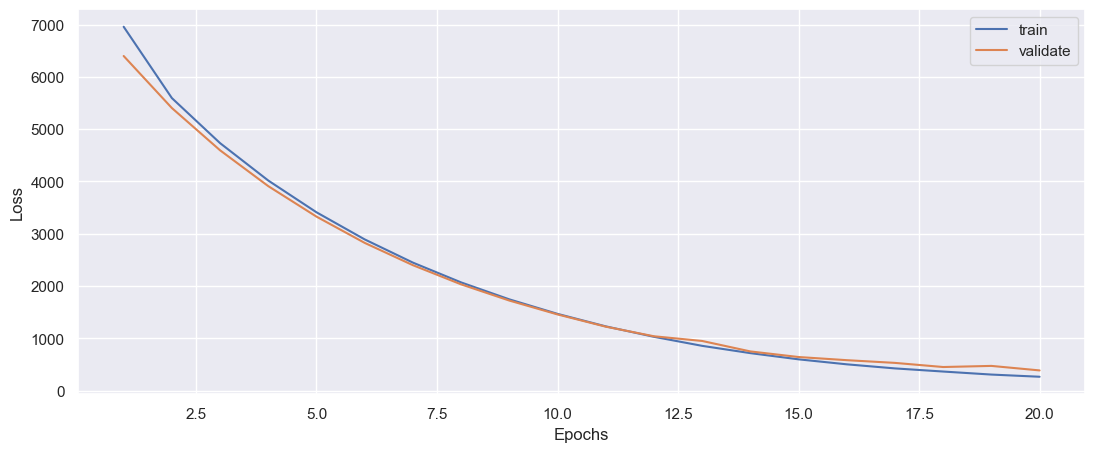

In [83]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [84]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

280/280 [==============================] - 2s 3ms/step
train set RMSE:16.435710906982422, R2:0.8453481162068582
2/2 [==============================] - 0s 5ms/step
test set RMSE:26.244645495278835, R2:-2.307473791946505
